<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/autoencoder_odsc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders for Outlier Detection

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
# mpl.rcParams["figure.dpi"] = 300

mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [3]:
import numpy as np
np.random.seed(42)

In [4]:
import tensorflow as tf
tf.random.set_seed(42)
tf.__version__

'2.12.0'

In [5]:
!nvidia-smi

Thu Jun  8 11:10:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Step 1: Load and prepare data

In [6]:
# screenshots from the application that is supposed to be mainly correct
!curl -O https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/app-testing/golden-master.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7589k  100 7589k    0     0  24.4M      0 --:--:-- --:--:-- --:--:-- 24.4M


In [7]:
!unzip -jqo golden-master.zip -d train

In [8]:
!ls train

100.png  16.png   238.png  306.png  375.png  443.png  5.png	  big-39.png
101.png  170.png  239.png  307.png  376.png  444.png  60.png	  big-3.png
102.png  171.png  23.png   308.png  377.png  445.png  61.png	  big-40.png
103.png  172.png  240.png  309.png  378.png  446.png  62.png	  big-41.png
104.png  173.png  241.png  30.png   379.png  447.png  63.png	  big-42.png
105.png  174.png  242.png  310.png  37.png   448.png  64.png	  big-43.png
106.png  175.png  243.png  311.png  380.png  449.png  65.png	  big-44.png
107.png  176.png  244.png  312.png  381.png  44.png   66.png	  big-45.png
108.png  177.png  245.png  313.png  382.png  450.png  67.png	  big-46.png
109.png  178.png  246.png  314.png  383.png  451.png  68.png	  big-47.png
10.png	 179.png  247.png  315.png  384.png  452.png  69.png	  big-48.png
110.png  17.png   248.png  316.png  385.png  453.png  6.png	  big-49.png
111.png  180.png  249.png  317.png  386.png  454.png  70.png	  big-4.png
112.png  181.png  24.png   318.png  387.png

In [9]:
# screenshots from the new version containing regressions
!curl -O https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/app-testing/regression.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  830k  100  830k    0     0  3417k      0 --:--:-- --:--:-- --:--:-- 3417k


In [10]:
!unzip -jqo regression.zip -d test

In [11]:
# !ls -l test

In [12]:
# for a symmetric form of the autoencoder, a power of two for the resolution is easiest
res = (256, 256)
x_res, y_res = res

In [13]:
color = False
# color = True
# color_channels = 3
color_channels = 1

In [14]:
import os
import numpy as np
from skimage import data, io, filters
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.color import rgb2gray, rgba2rgb

def read_images_from_dir(data_dir, dims=(356, 384), res=(256, 256), type = ".png"):
  x_res, y_res = res
  x_dim, y_dim = dims
  images = []
  file_names = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(type)]
  for f in file_names:
    image = io.imread(f)
    # some images from regressed application often have an additional line break
    # we take the easy route and simply clip to have the same size for all images
    image = image[:x_dim, :y_dim]
    image = image[:,:,:3] # might have 4 color channels, but rgb2gray expects 3
    if color:
      pass
      # getting rid of alpha channel (going from 4 to 3 color channels)
      # image = rgba2rgb(image) # seems to mess up values and shifts them slightly beyond 1
    else:
      image = rgb2gray(image) # seems to mess up values and shifts them slightly beyond 1
    image = resize(image, (x_res, y_res))
    images.append(image)

  images = np.array(images)
  images = np.clip(images, 0, 1) # fixing fuckup of rgb2gray

  return images

In [15]:
def plot_samples(x, n_samples=15):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      if color:
        ax.imshow(x[index])
      else:
        ax.imshow(x[index], cmap="gray")
      ax.set_title("{}".format(index))

## Training data
### Assumed to be mostly correct

In [16]:
train = read_images_from_dir("train")
train.shape, train.dtype

((603, 256, 256), dtype('float64'))

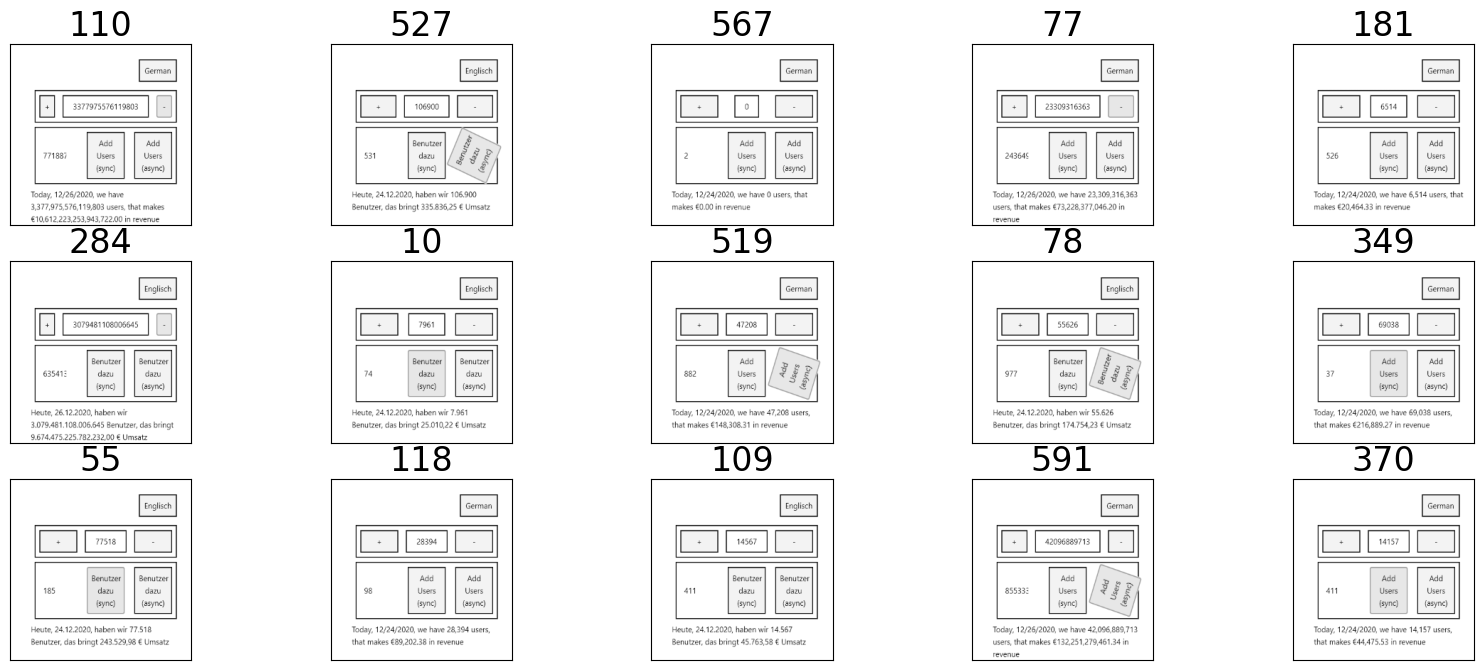

In [17]:
plot_samples(train)

## Test data
### Assumed to be mostly broken

In [18]:
test = read_images_from_dir("test")
test.shape, test.dtype

((51, 256, 256), dtype('float64'))

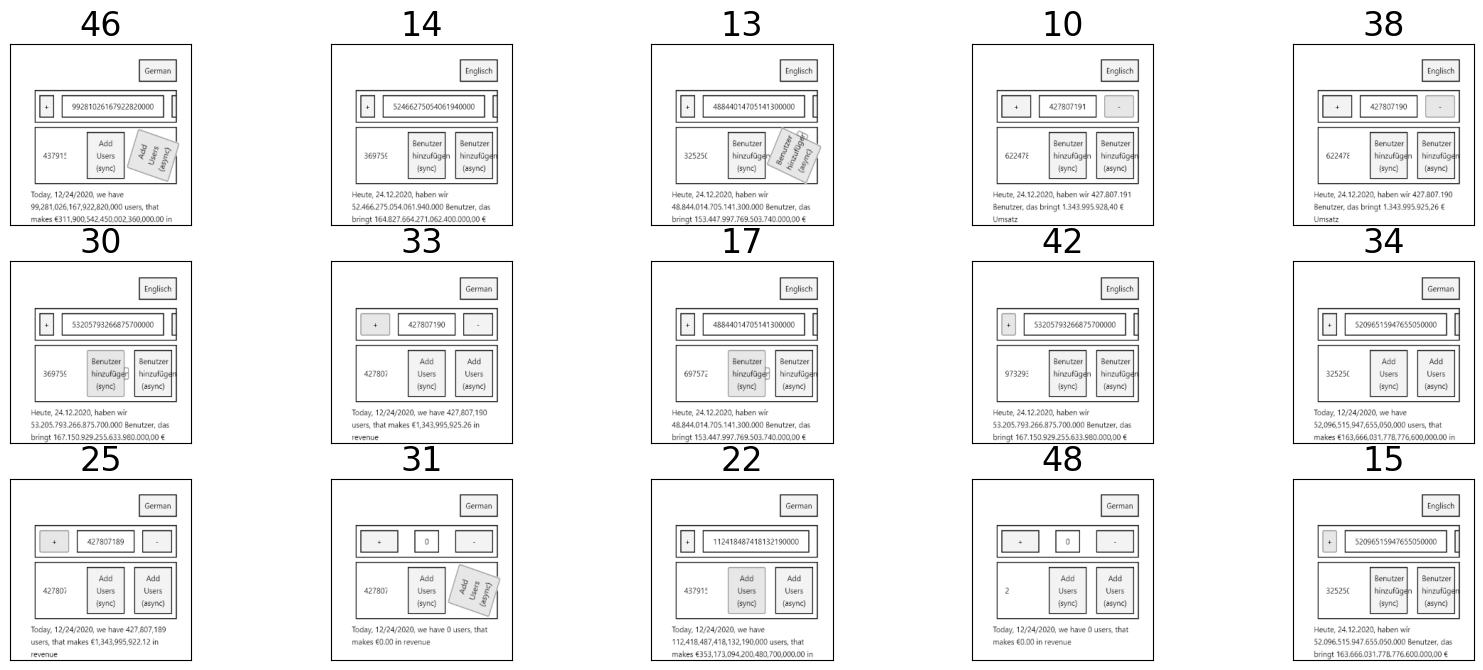

In [19]:
plot_samples(test)

# Step 2: Train a Deep CNN Autoencoder

* Encoder uses convolutional layers
* Decoder does deconvoluation
* Bottleneck minimally uses 8 neurons, but these can be easily configured. Less than 8 will probably not train
* l2 to compress latent space a bit
* could use l1 to increase sparsity of embedding when having dim > 2, to have an additional restriction (often gives better results)
*  rounded accuracy counts how many pixels match approximately

In [20]:
from tensorflow import keras

# rounded to b/w, how many pixels fit approximately?
# taken from: https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb#scrollTo=vTfcqDgW-Kff
@tf.function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [21]:
def rounded_accuracy_for_single_image(true, predicted):
  return tf.reduce_mean(rounded_accuracy(true, predicted.astype('float64'))).numpy()    

In [22]:
# going much lower will not work
# encoding_dim = 8
encoding_dim = 32
# seems to work a bit nicer, but reducing for viz gives worse results
# encoding_dim = 16

In [23]:
input_shape = train.shape[1:]
input_shape

(256, 256)

In [24]:
compression_rate = input_shape[0] * input_shape[1] / encoding_dim
compression_rate

2048.0

In [25]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

In [26]:
from lrcurve import KerasLearningCurve

In [27]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape, Flatten
from tensorflow.keras.models import Model, Sequential

from tensorflow import keras

kernel_size = 4
stride = 2

conv_encoder = Sequential([
    Input(shape=input_shape),
    Reshape((x_res, y_res, color_channels)),
    Conv2D(64, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(16, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    Flatten(),
    # this creates our latent representation
    Dense(encoding_dim, 
          name='latent_representation',
          # activation="relu", 
          activation="linear", 
         ),

])
conv_decoder = Sequential([
    # this accepts the latent representation
    Input(shape=(encoding_dim)),
    Dense(1024),
    Reshape((32, 32, 1)),
    Conv2DTranspose(32, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    Conv2DTranspose(64, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    UpSampling2D(size=2),
    Conv2DTranspose(color_channels, kernel_size=kernel_size, strides=1, padding="same", activation="sigmoid"),
    Reshape(input_shape)
])
conv_ae = Sequential([conv_encoder, conv_decoder])

conv_ae.compile(
    optimizer='adam',
    # optimizer='sgd', # will not train
    loss="binary_crossentropy", 
    # loss="mae", # will not train either 
    # loss="mse", # will not train either
    metrics=[rounded_accuracy])

# conv_encoder.summary()
# conv_decoder.summary()

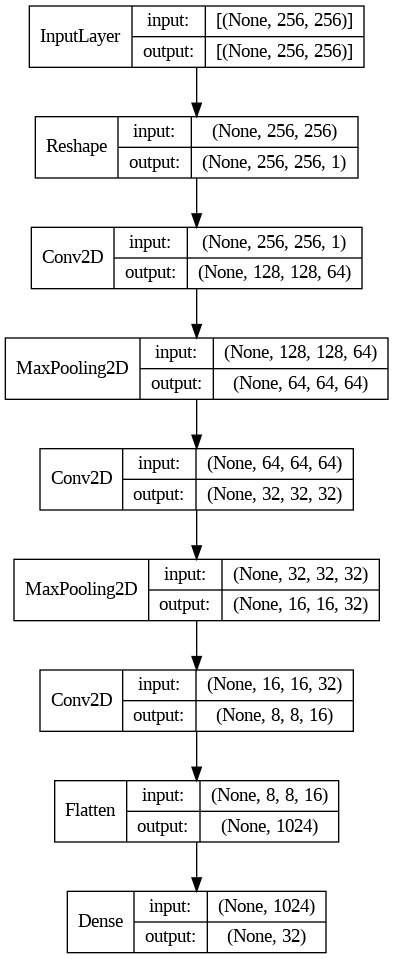

In [28]:
from tensorflow.keras.utils import plot_model
# plot_model(conv_encoder, to_file="encoder.png", show_shapes=True, show_layer_names=False, dpi=300)
plot_model(conv_encoder, show_shapes=True, show_layer_names=False)

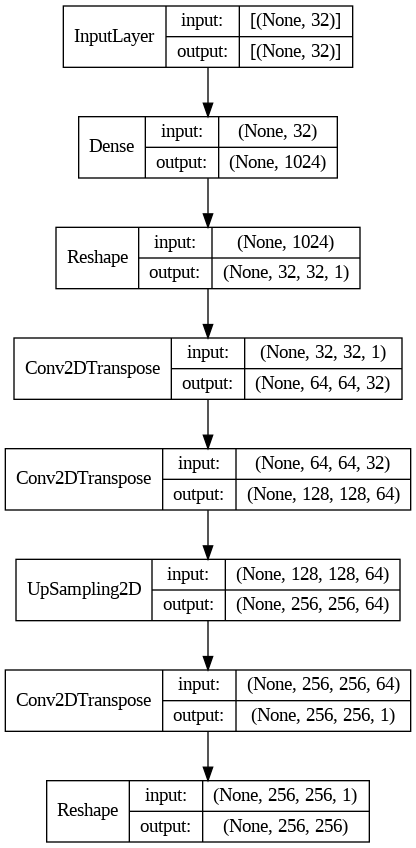

In [29]:
# plot_model(conv_decoder, to_file="decoder.png", show_shapes=True, show_layer_names=False, dpi=300)
plot_model(conv_decoder, show_shapes=True, show_layer_names=False)

In [30]:
%%time

# ~2:00 on a weak GPU like T4
# ~12:00 on a weak CPU like i5

# bring this down if training does not work any more
# can be higher when dimension of hidden representation is higher
BATCH_SIZE = 4 # for 16
# BATCH_SIZE = 2 # for 8
# typically is more than enough
# EPOCHS = 100
EPOCHS = 50
# consider when running on CPU
# EPOCHS = 10

# input and output are the same
history = conv_ae.fit(train, train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(test, test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)

CPU times: user 1min 22s, sys: 4.17 s, total: 1min 26s
Wall time: 2min 24s


In [31]:
train_loss, train_accuracy = conv_ae.evaluate(train, train, batch_size=BATCH_SIZE, verbose=0)
train_accuracy

0.9885735511779785

In [32]:
test_loss, test_accuracy = conv_ae.evaluate(test, test, batch_size=BATCH_SIZE, verbose=0)
test_accuracy

0.9775322079658508

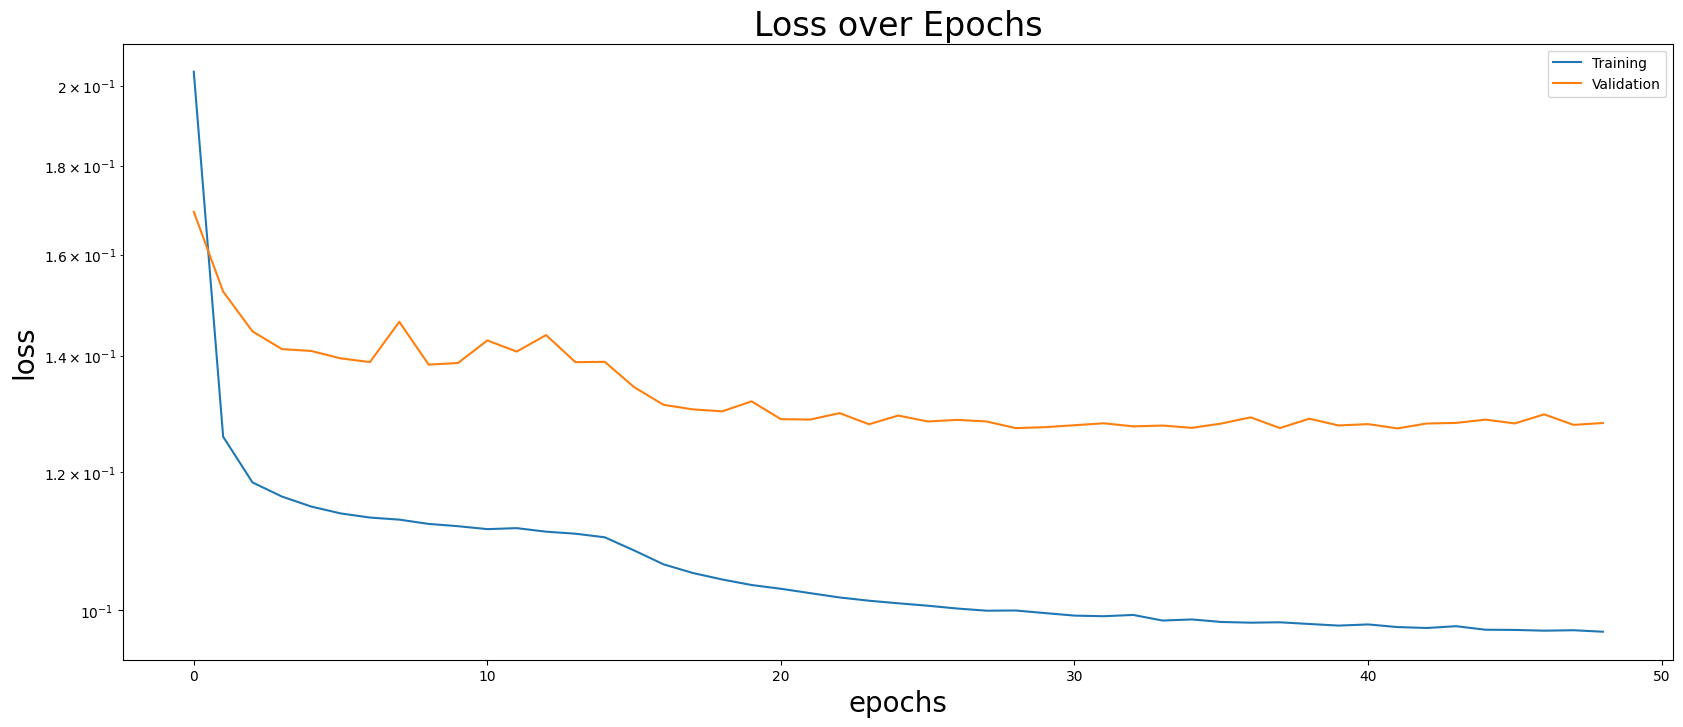

In [33]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Validation']);

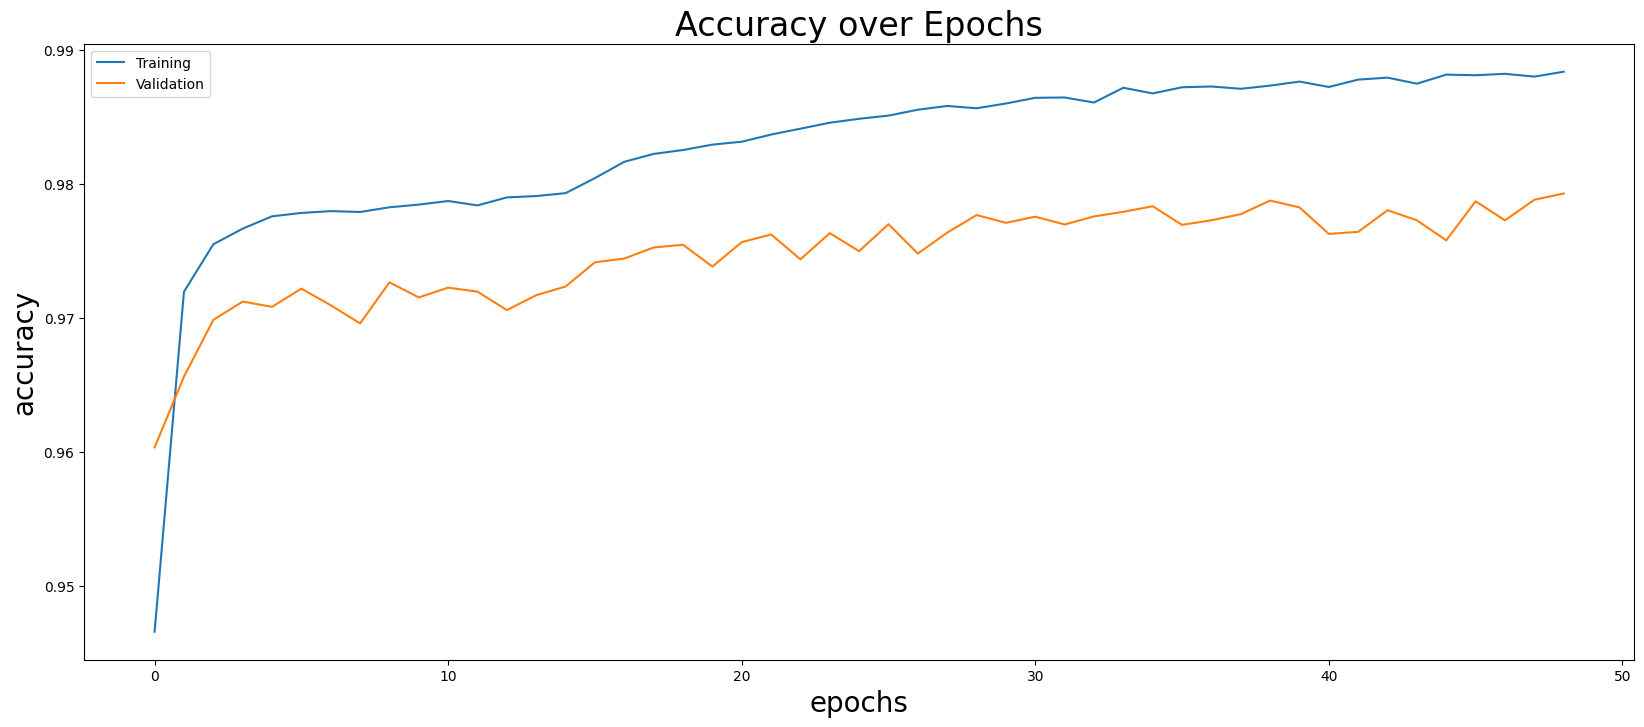

In [34]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over Epochs')

plt.plot(history.history['rounded_accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_rounded_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Validation']);

# Step 3: Validate Results

In [35]:
train_pred = conv_ae.predict(train)
# plot_samples(train_pred)

19/19 [==============================] - 2s 61ms/step


### True

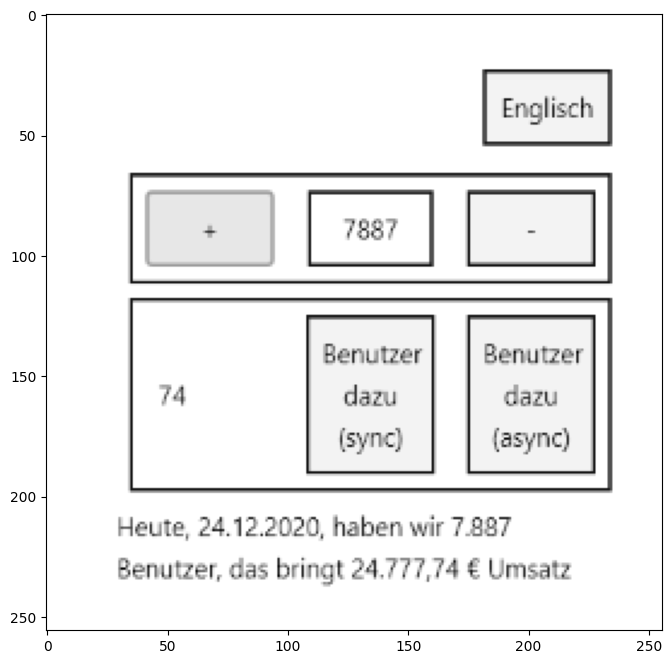

In [36]:
index = 50
if color:
  plt.imshow(train[index]);
else:
  plt.imshow(train[index], cmap='gray');

# io.imsave('train_true.png', train[index])

### Reproduction

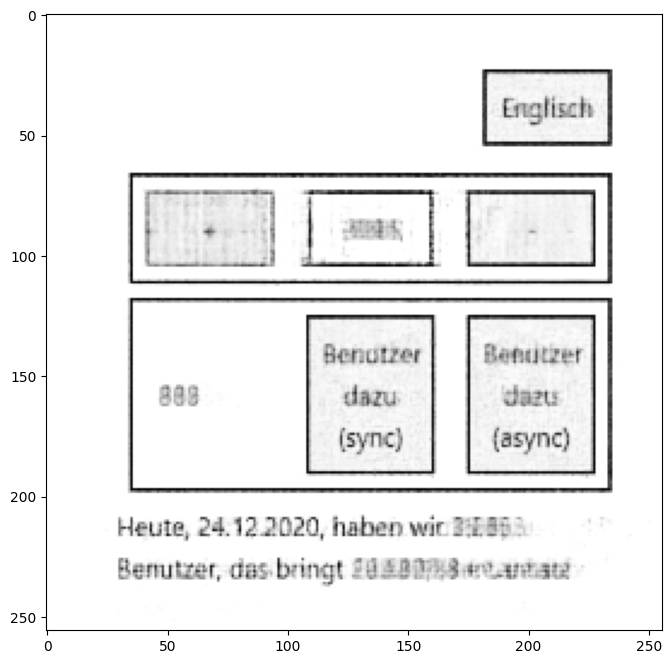

In [37]:
if color:
  plt.imshow(train_pred[index]);
else:
  plt.imshow(train_pred[index], cmap='gray');

# io.imsave('train_pred.png', train_pred[index])

In [38]:
rounded_accuracy_for_single_image(train[index], train_pred[index])

0.99017334

## Test, the ones that are actually mostly broken

In [39]:
test_pred = conv_ae.predict(test)
# plot_samples(test_pred)

2/2 [==============================] - 0s 410ms/step


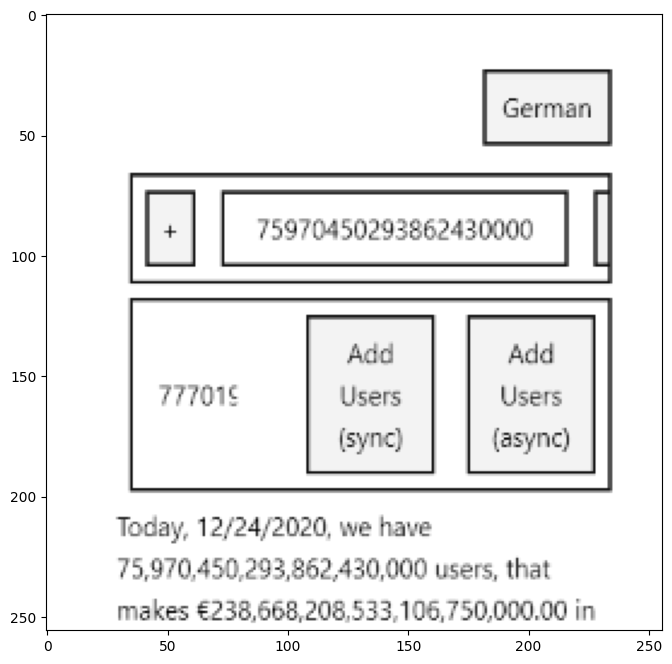

In [40]:
# index = 21
index = 24
if color:
  plt.imshow(test[index]);
else:
  plt.imshow(test[index], cmap='gray');

# io.imsave('test_true.png', test[index])

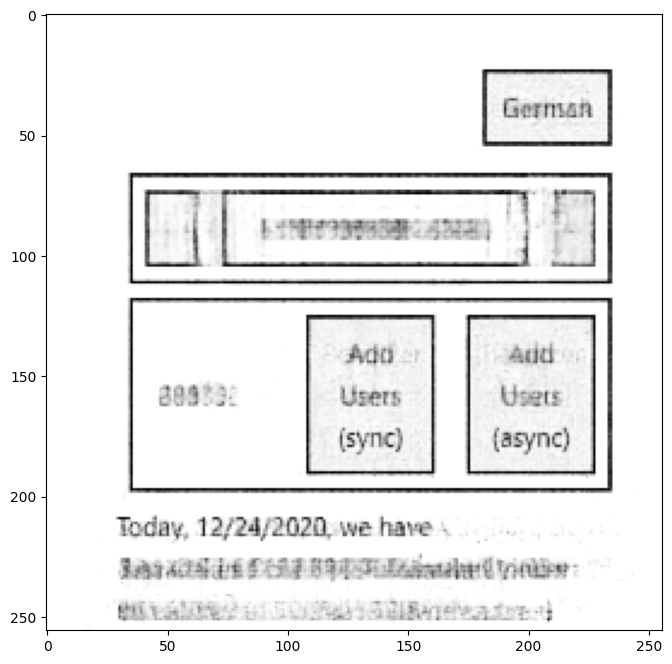

In [41]:
if color:
  plt.imshow(test_pred[index]);
else:
  plt.imshow(test_pred[index], cmap='gray');

# io.imsave('test_pred.png', test_pred[index])

In [42]:
rounded_accuracy_for_single_image(test[0], test_pred[0])

0.9777374

## Comparing samples from Training Set

In [43]:
def compare_samples(x, x_pred, n_samples=5, display_accuracy=True):
  n_samples = min(n_samples, len(x))
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(2, n_samples, i + 1, xticks=[], yticks=[])
      ax.set_title("{}".format(index))
      if color:
        ax.imshow(x[index])
      else:
        ax.imshow(x[index], cmap="gray")
      ax = figure.add_subplot(2, n_samples, i + 1 + n_samples, xticks=[], yticks=[])
      if display_accuracy:
        acc = rounded_accuracy_for_single_image(x[index], x_pred[index])
        ax.set_title("{:.4f}".format(acc))
      if color:
        ax.imshow(x_pred[index])
      else:
        ax.imshow(x_pred[index], cmap="gray")

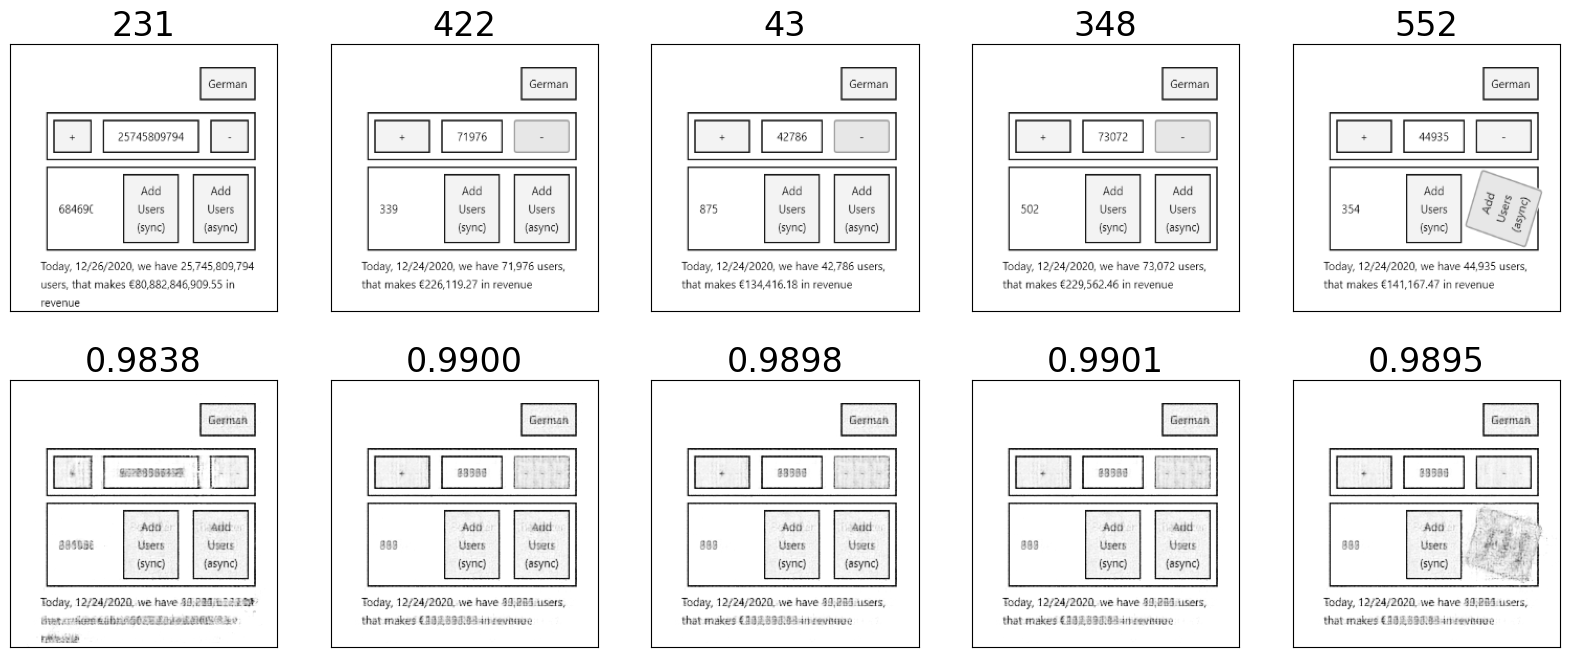

In [44]:
compare_samples(train, train_pred)

In [45]:
scores = []
for true_image, predicted_image in zip(train, train_pred):
  score = rounded_accuracy_for_single_image(true_image, predicted_image)
  scores.append(score)
train_scores = np.array(scores)  
train_scores.shape

(603,)

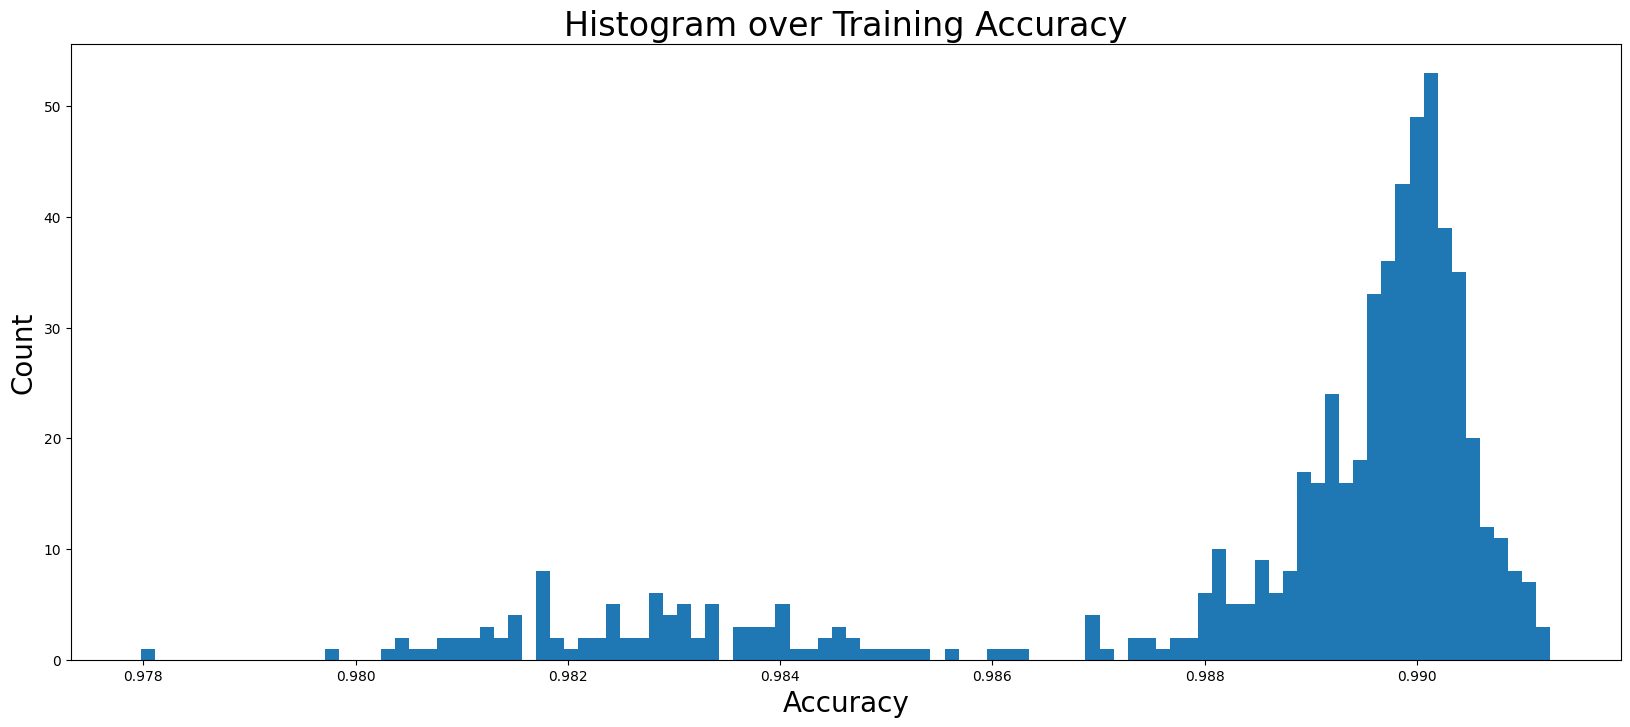

In [46]:
plt.title('Histogram over Training Accuracy')
plt.ylabel("Count")
plt.xlabel("Accuracy")

plt.hist(train_scores, bins=100);

## Comparing samples from Regression Test Set

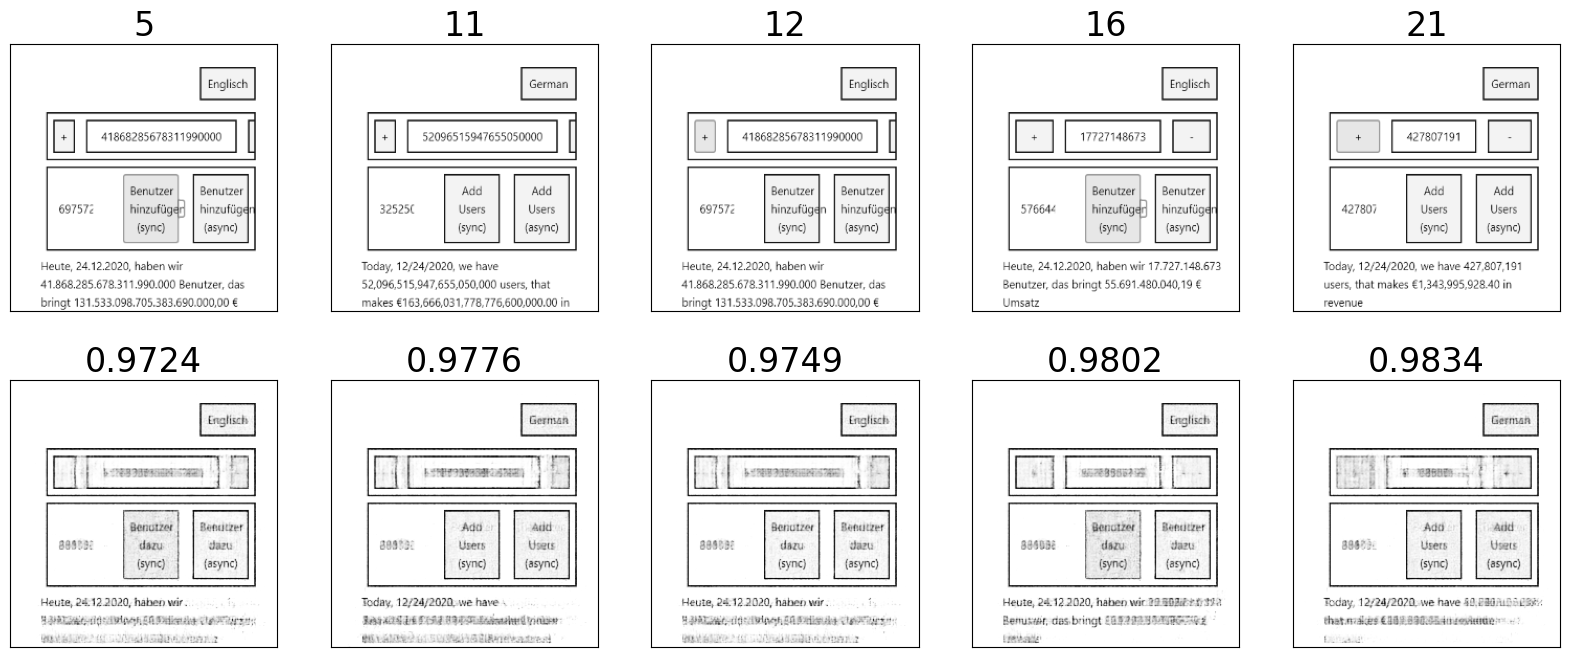

In [47]:
compare_samples(test, test_pred)

In [48]:
scores = []
for true_image, predicted_image in zip(test, test_pred):
  score = rounded_accuracy_for_single_image(true_image, predicted_image)
  scores.append(score)
test_scores = np.array(scores)  
test_scores.shape

(51,)

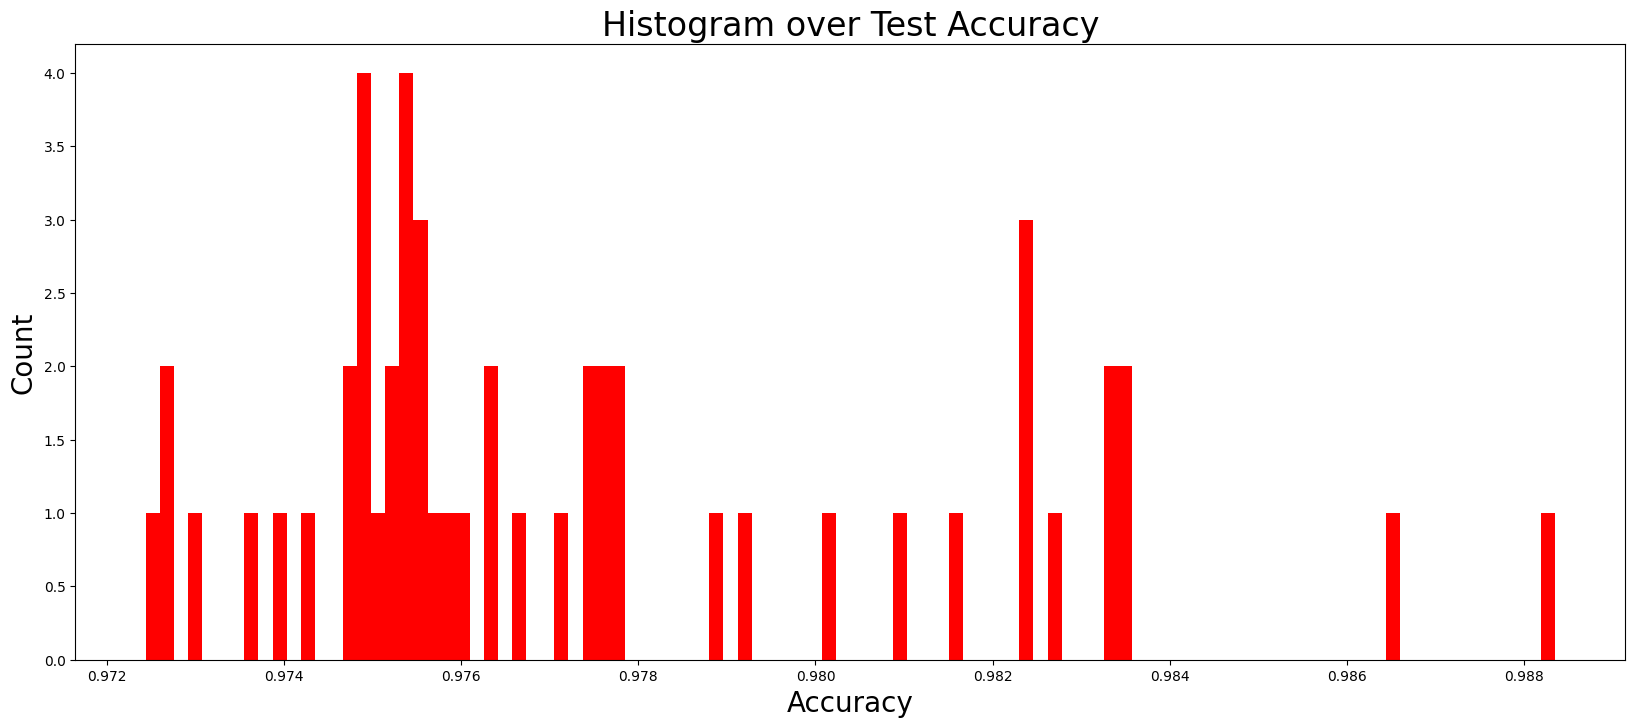

In [49]:
plt.title('Histogram over Test Accuracy')
plt.ylabel("Count")
plt.xlabel("Accuracy")

plt.hist(test_scores, bins=100, color='red');

# Step 4: Identify suspicious screenshots from test set

Suspicious Screenshots: 41 von 51
Unsuspicious Screenshots: 570 von 603


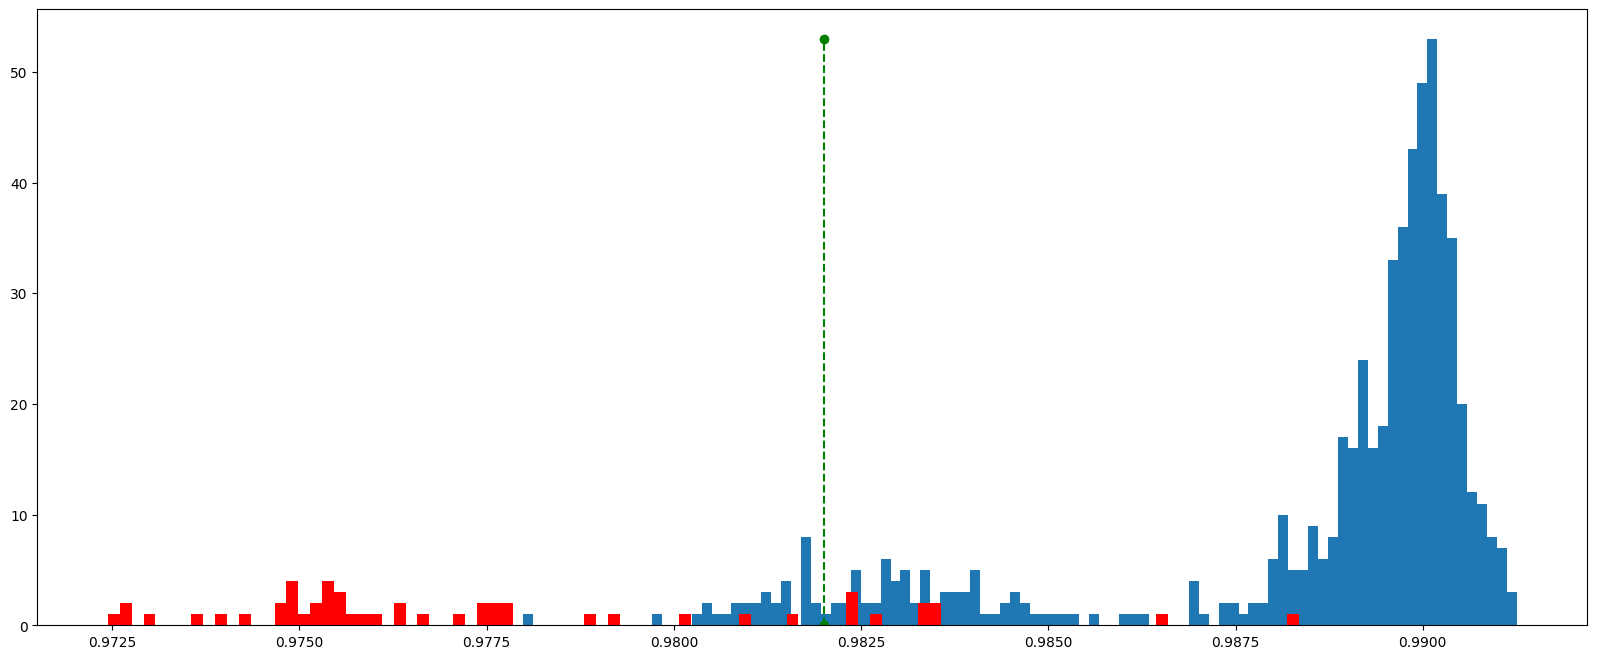

In [50]:
#@title Threshold: below which matching score do we consider a screenshot suspicious?  { run: "auto", display-mode: "form" }

threshold = 0.982 #@param {type:"slider", min:0.95, max:1.0, step:0.0005}
test_mask = test_scores < threshold
train_mask = train_scores >= threshold
n, _, _ = plt.hist(train_scores, bins=100);
plt.hist(test_scores, bins=100, color='red')
plt.plot((threshold, threshold), (0, n.max()),  color='green', marker='o', linestyle='dashed');
print("Suspicious Screenshots: {:d} von {:d}".format(np.count_nonzero(test_mask), test_mask.shape[0]));
print("Unsuspicious Screenshots: {:d} von {:d}".format(np.count_nonzero(train_mask), train_mask.shape[0]));

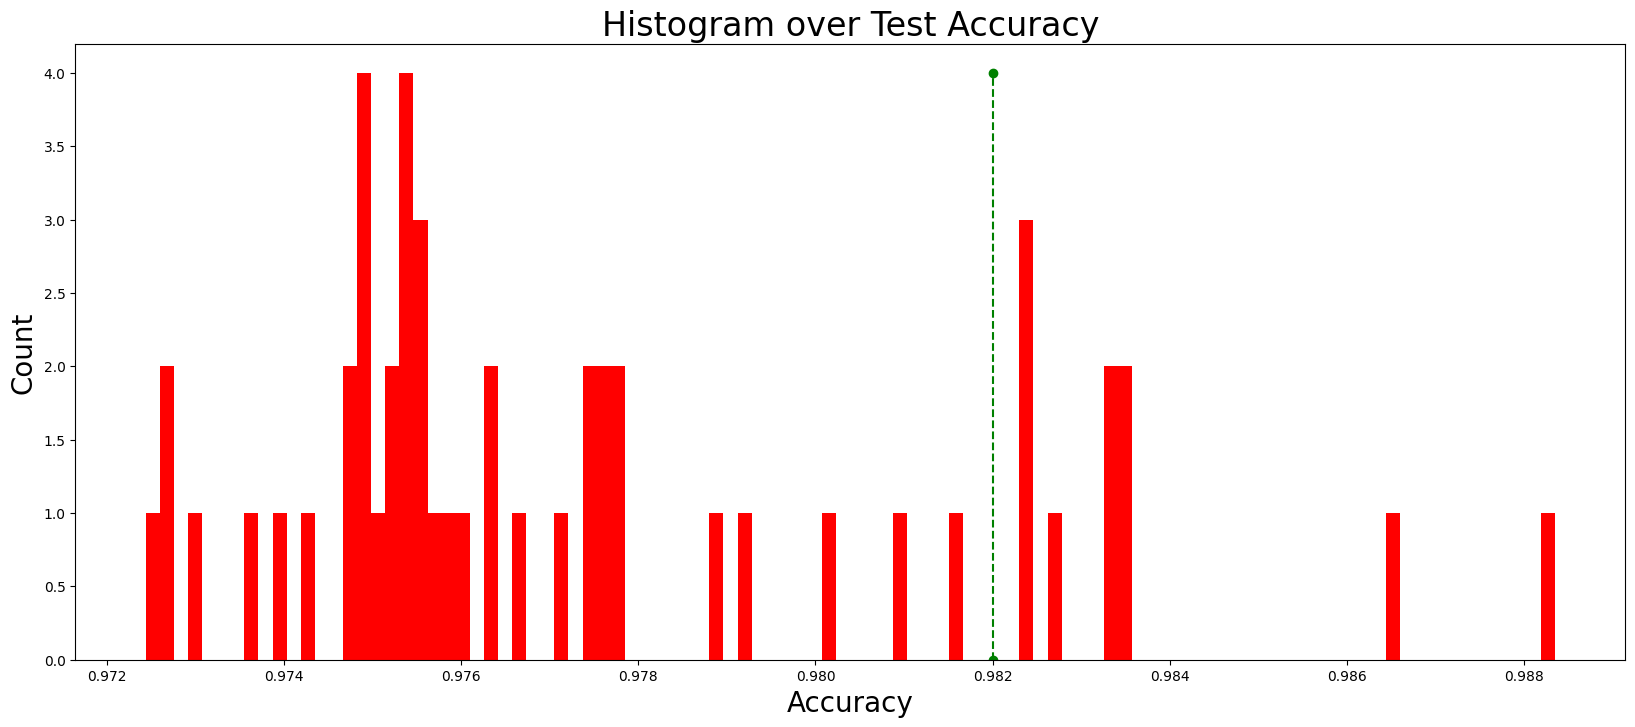

In [51]:
plt.title('Histogram over Test Accuracy')
plt.ylabel("Count")
plt.xlabel("Accuracy")

n, _, _ = plt.hist(test_scores, bins=100, color='red')
plt.plot((threshold, threshold), (0, n.max()),  color='green', marker='o', linestyle='dashed');

## Predicted as correct

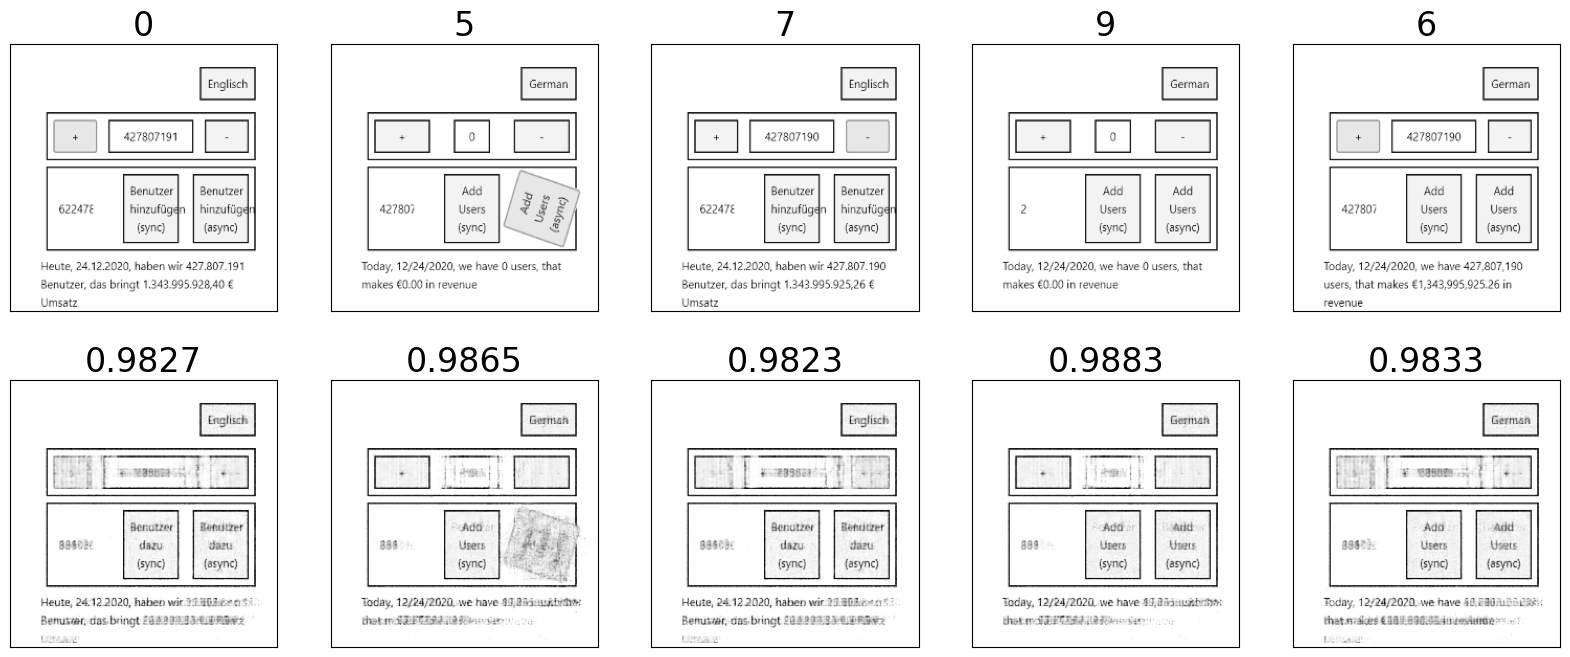

In [52]:
compare_samples(test[~test_mask], test_pred[~test_mask])

## Predicted as broken

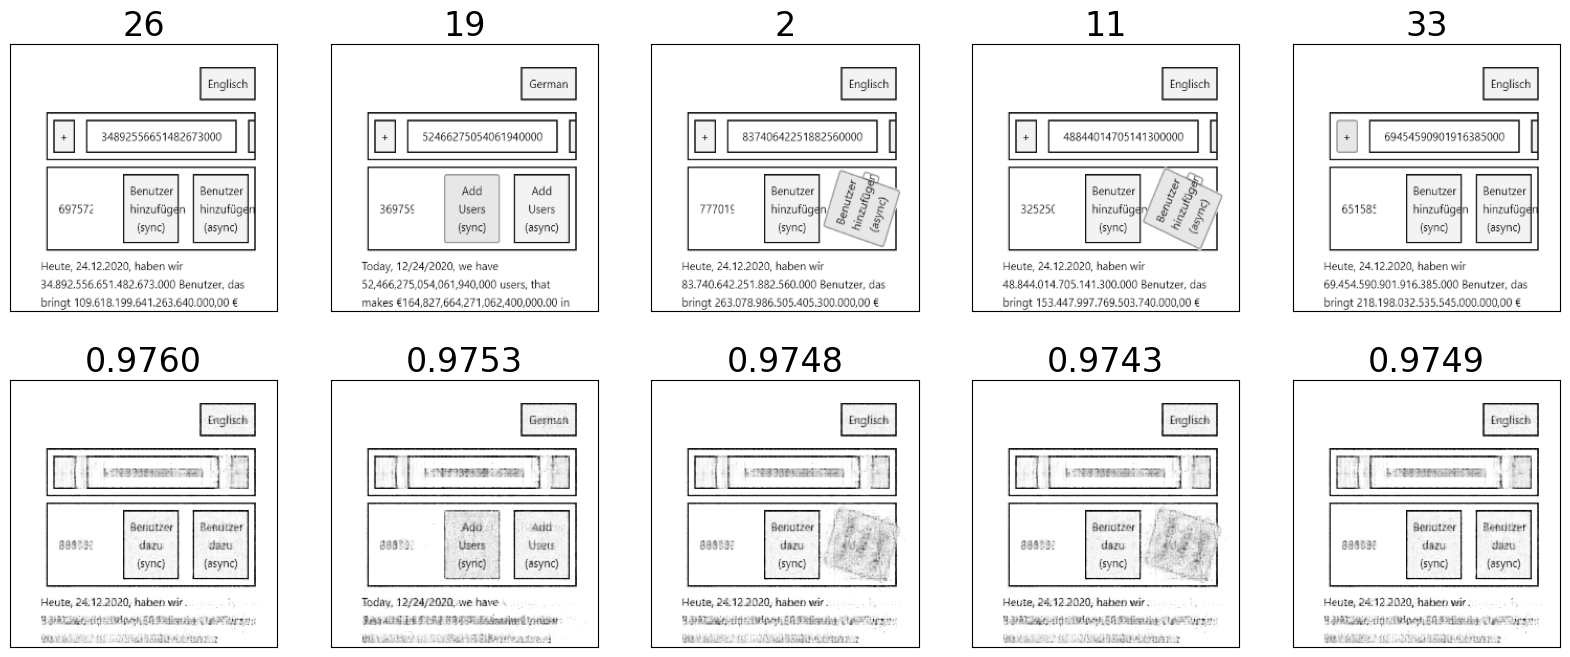

In [53]:
compare_samples(test[test_mask], test_pred[test_mask])

# Step 5: Looking at our embeddings

**Motivation: What to do if this is not just binary or you have normal data is not the majority?**

* analyse using standard tools for unsupervised learning
* embedding is seen as a smart dimensionality reduction
* decoder is only needed during training
* need to reduce to 2 dim to make them plotable
* would work without autoencoder, just by reducing image to 2d
  * however, results would be much less favorable
  * no knowledge about the domain (images) would be used in that case

In [54]:
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
# https://umap-learn.readthedocs.io/en/latest/parameters.html
# https://umap-learn.readthedocs.io/en/latest/how_umap_works.html
# https://pair-code.github.io/understanding-umap/
# https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668

!pip install umap-learn -q

In [55]:
import umap
umap.__version__

'0.5.3'

In [56]:
%%time

test_embedded_imgs = conv_encoder.predict(test)
if encoding_dim == 2:
  test_embedded_imgs = test_embedded_imgs
else:
  print('reducing dim using umap')
  # default
  reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
  # local structure (n_neighbors), a bit more stretched out (min_dist)
  # reducer = umap.UMAP(random_state=42, n_neighbors=5, min_dist=.99)
  test_embedded_imgs = reducer.fit_transform(test_embedded_imgs)

2/2 [==============================] - 0s 7ms/step
reducing dim using umap
CPU times: user 8.93 s, sys: 58.5 ms, total: 8.99 s
Wall time: 11.4 s


In [57]:
test_embedded_imgs.shape

(51, 2)

In [58]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
test_embedded_imgs = scaler.fit_transform(test_embedded_imgs)
test_embedded_imgs.shape

(51, 2)

In [59]:
# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

from PIL import Image

def plot_embeddings(embeddings_2d, images, min_dist = 0.2, zoom=0.1, plot_samples=True):
  plt.figure(figsize=(50, 50))
  cmap = plt.cm.tab10
  if plot_samples:
    image_positions = np.array([[1., 1.]])
    for index, position in enumerate(embeddings_2d):
        dist = np.sum((position - image_positions) ** 2, axis=1)
        if np.min(dist) > min_dist: # if far enough from other images
            image_positions = np.r_[image_positions, [position]]
            image = Image.fromarray(images[index])
            # image.putalpha(16)
            imagebox = mpl.offsetbox.AnnotationBbox(
                mpl.offsetbox.OffsetImage(image, cmap="gray", zoom=zoom ),
                position, 
                # bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2}
                )
            plt.gca().add_artist(imagebox)
  # plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100)
  plt.axis("off");

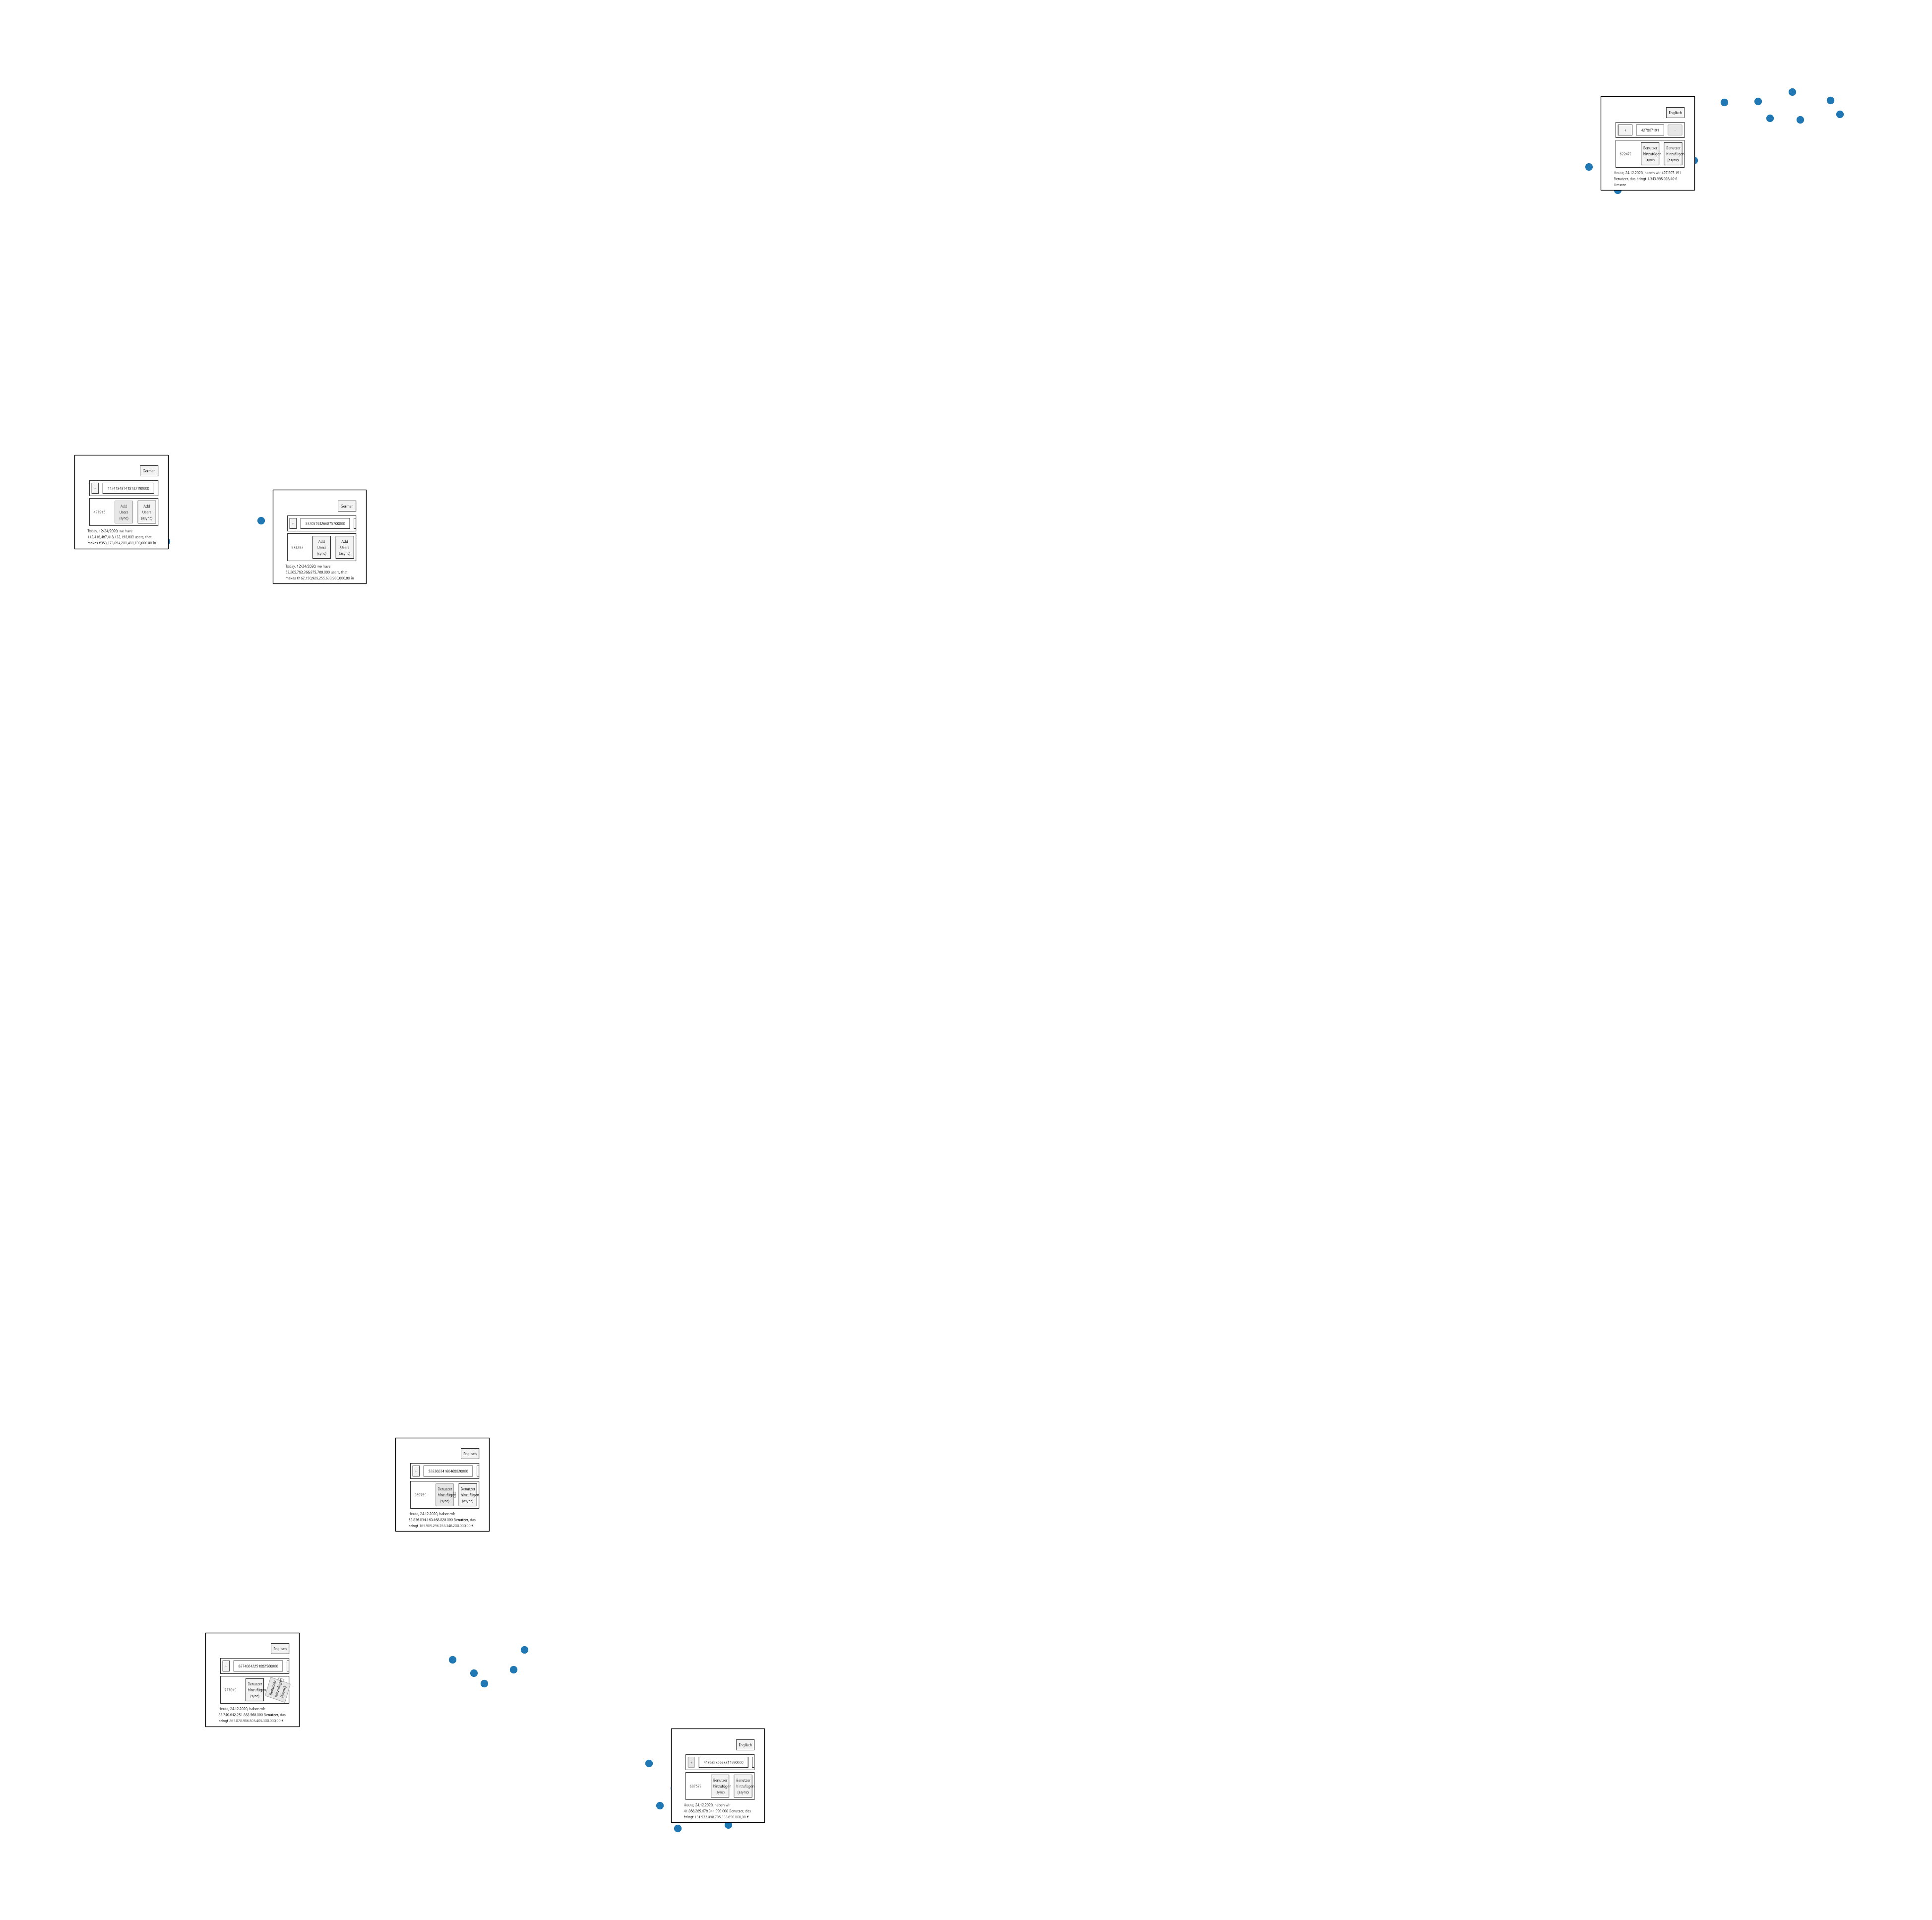

In [60]:
# how far need to labels be from each other in order not to clutter everthing
# might need a bit of adjustment 
min_dist = 0.1

# plot_embeddings(test_embedded_imgs, test, min_dist=min_dist, zoom=0.5, plot_samples=False)
plot_embeddings(test_embedded_imgs, test, min_dist=min_dist, zoom=0.5)

## Same for training data

19/19 [==============================] - 0s 7ms/step
reducing dim using umap


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


CPU times: user 2.81 s, sys: 241 ms, total: 3.05 s
Wall time: 5.34 s


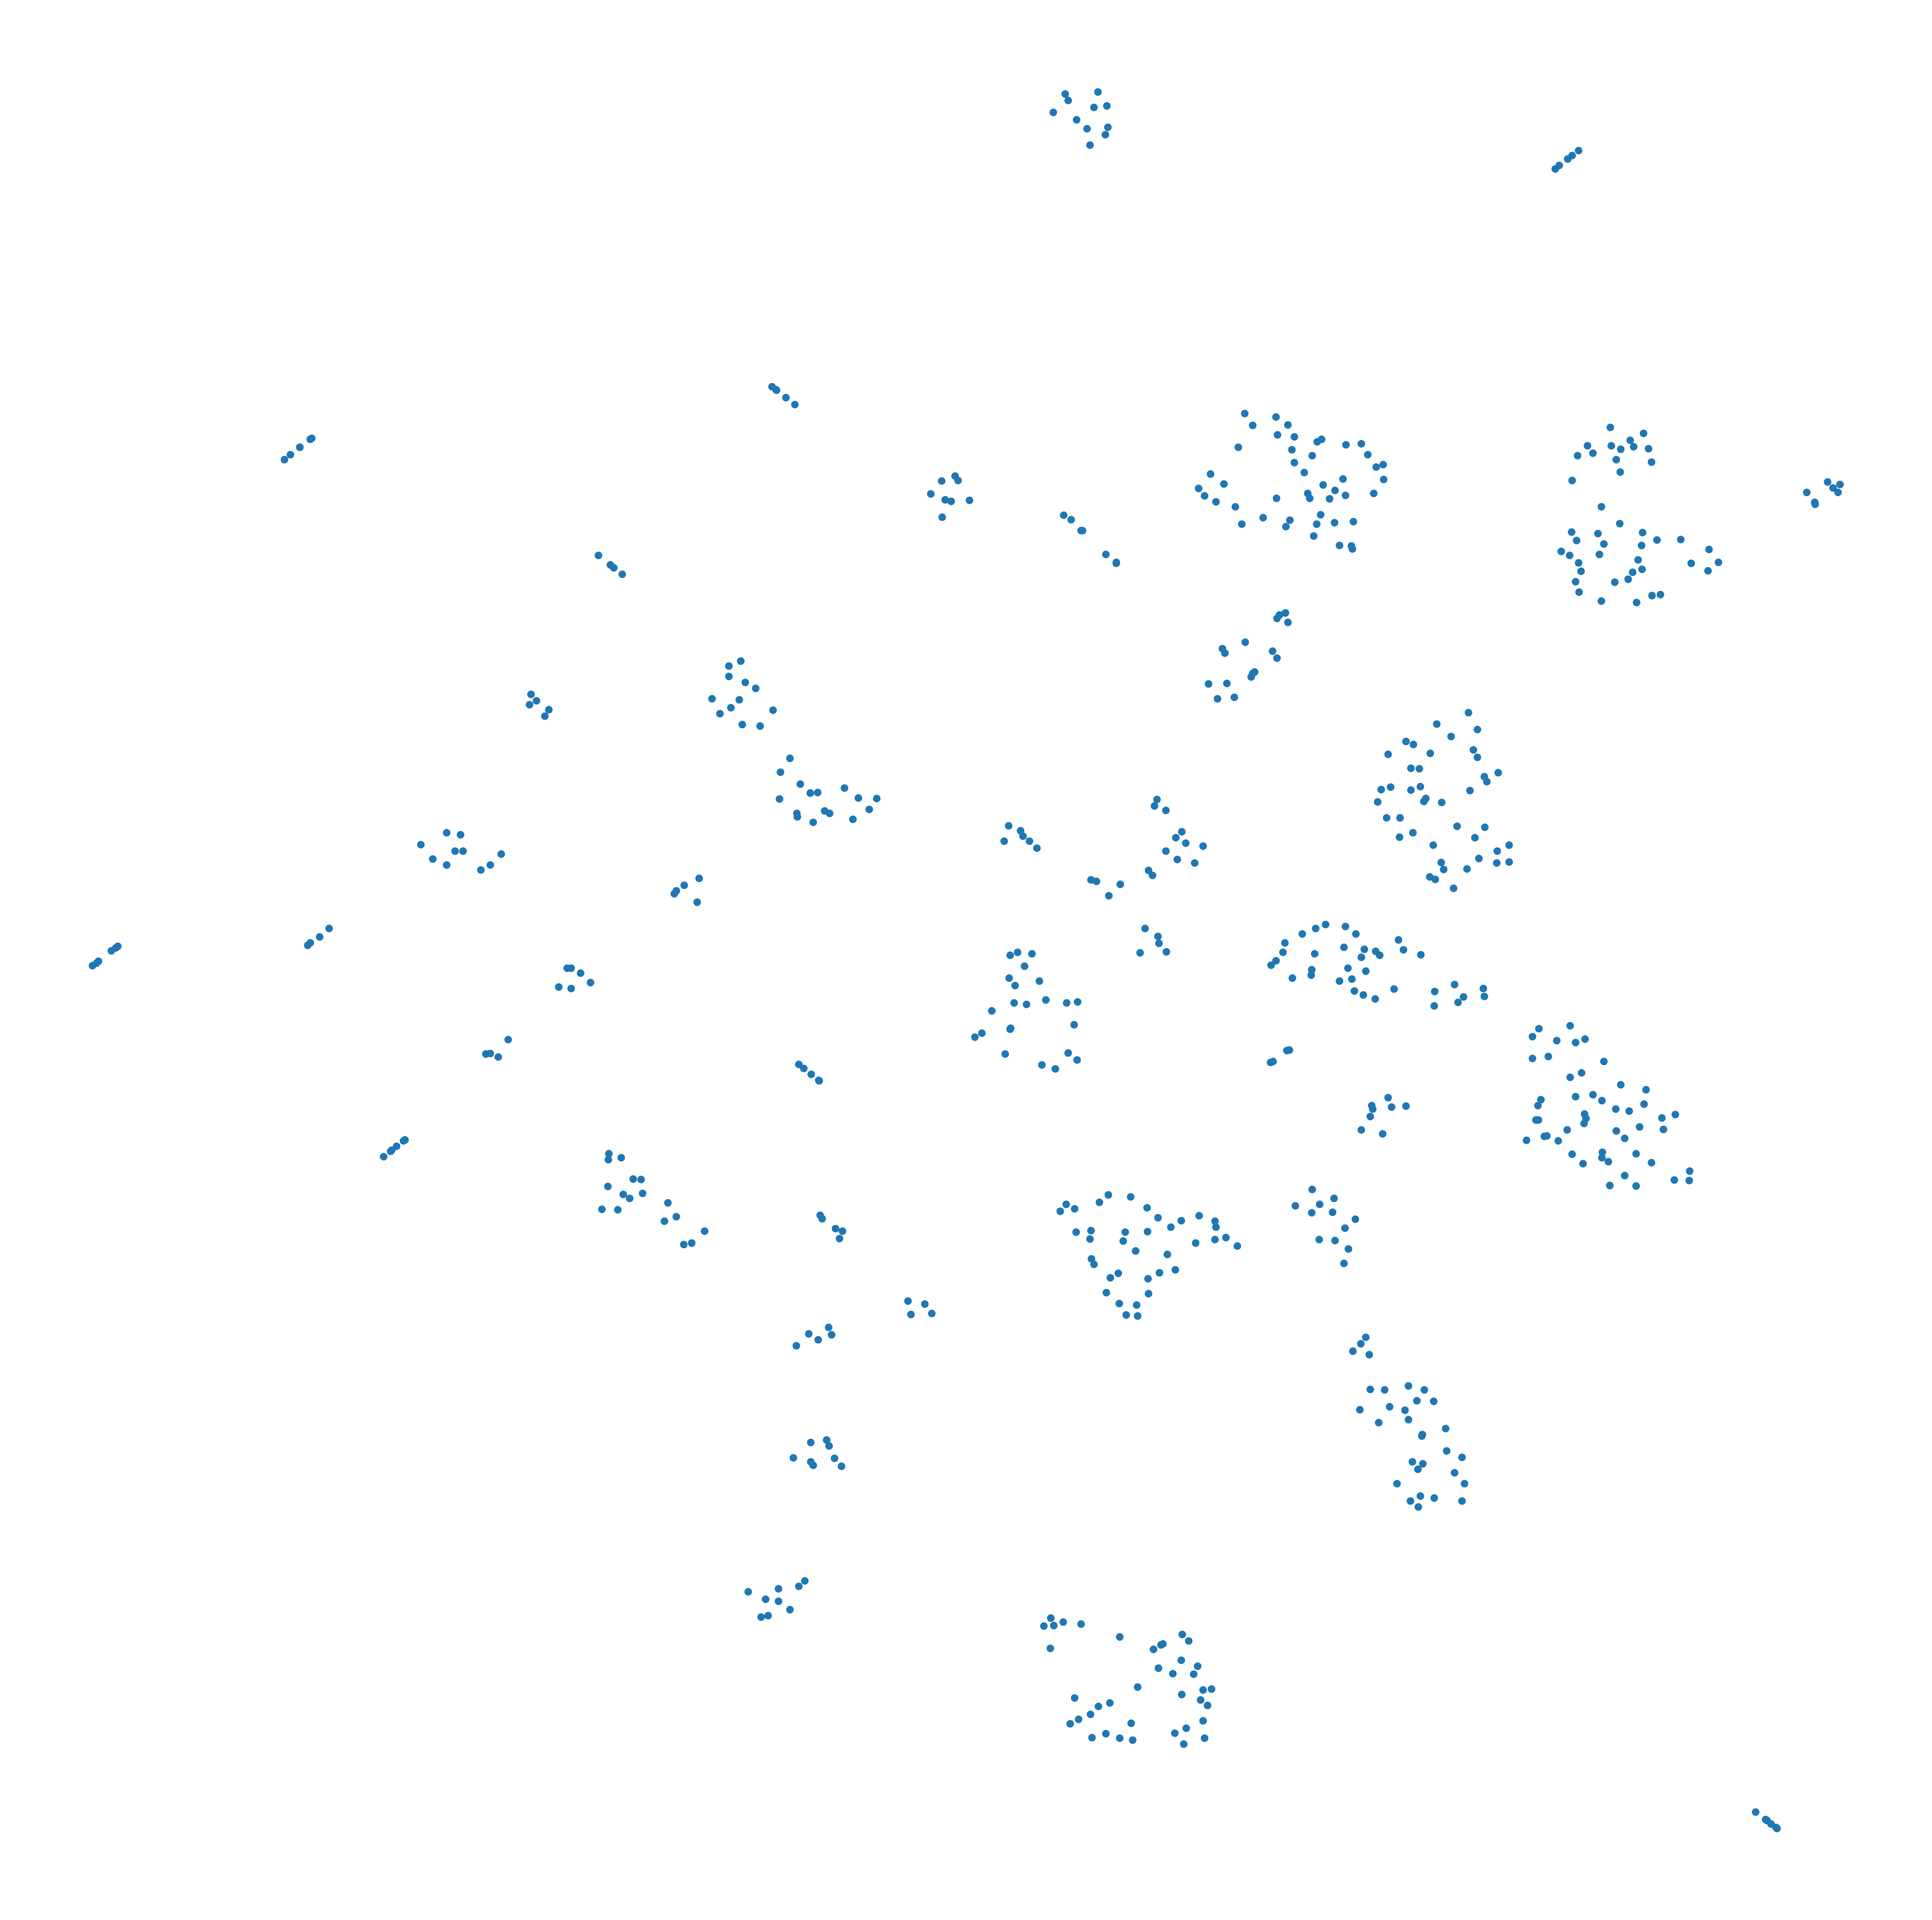

In [61]:
%%time

train_embedded_imgs = conv_encoder.predict(train)
# just for shits and giggles: use raw flattened image data
# train_embedded_imgs = train.reshape(train.shape[0], -1)

if encoding_dim == 2:
  train_embedded_imgs = train_embedded_imgs
else:
  print('reducing dim using umap')
  # default
  # reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
  # local structure (n_neighbors), a bit more stretched out (min_dist)
  reducer = umap.UMAP(random_state=42, n_neighbors=5, min_dist=.99)
  train_embedded_imgs = reducer.fit_transform(train_embedded_imgs)

train_embedded_imgs = scaler.fit_transform(train_embedded_imgs)

min_dist = 0.1

plot_embeddings(train_embedded_imgs, train, min_dist=min_dist, zoom=0.5, plot_samples=False)

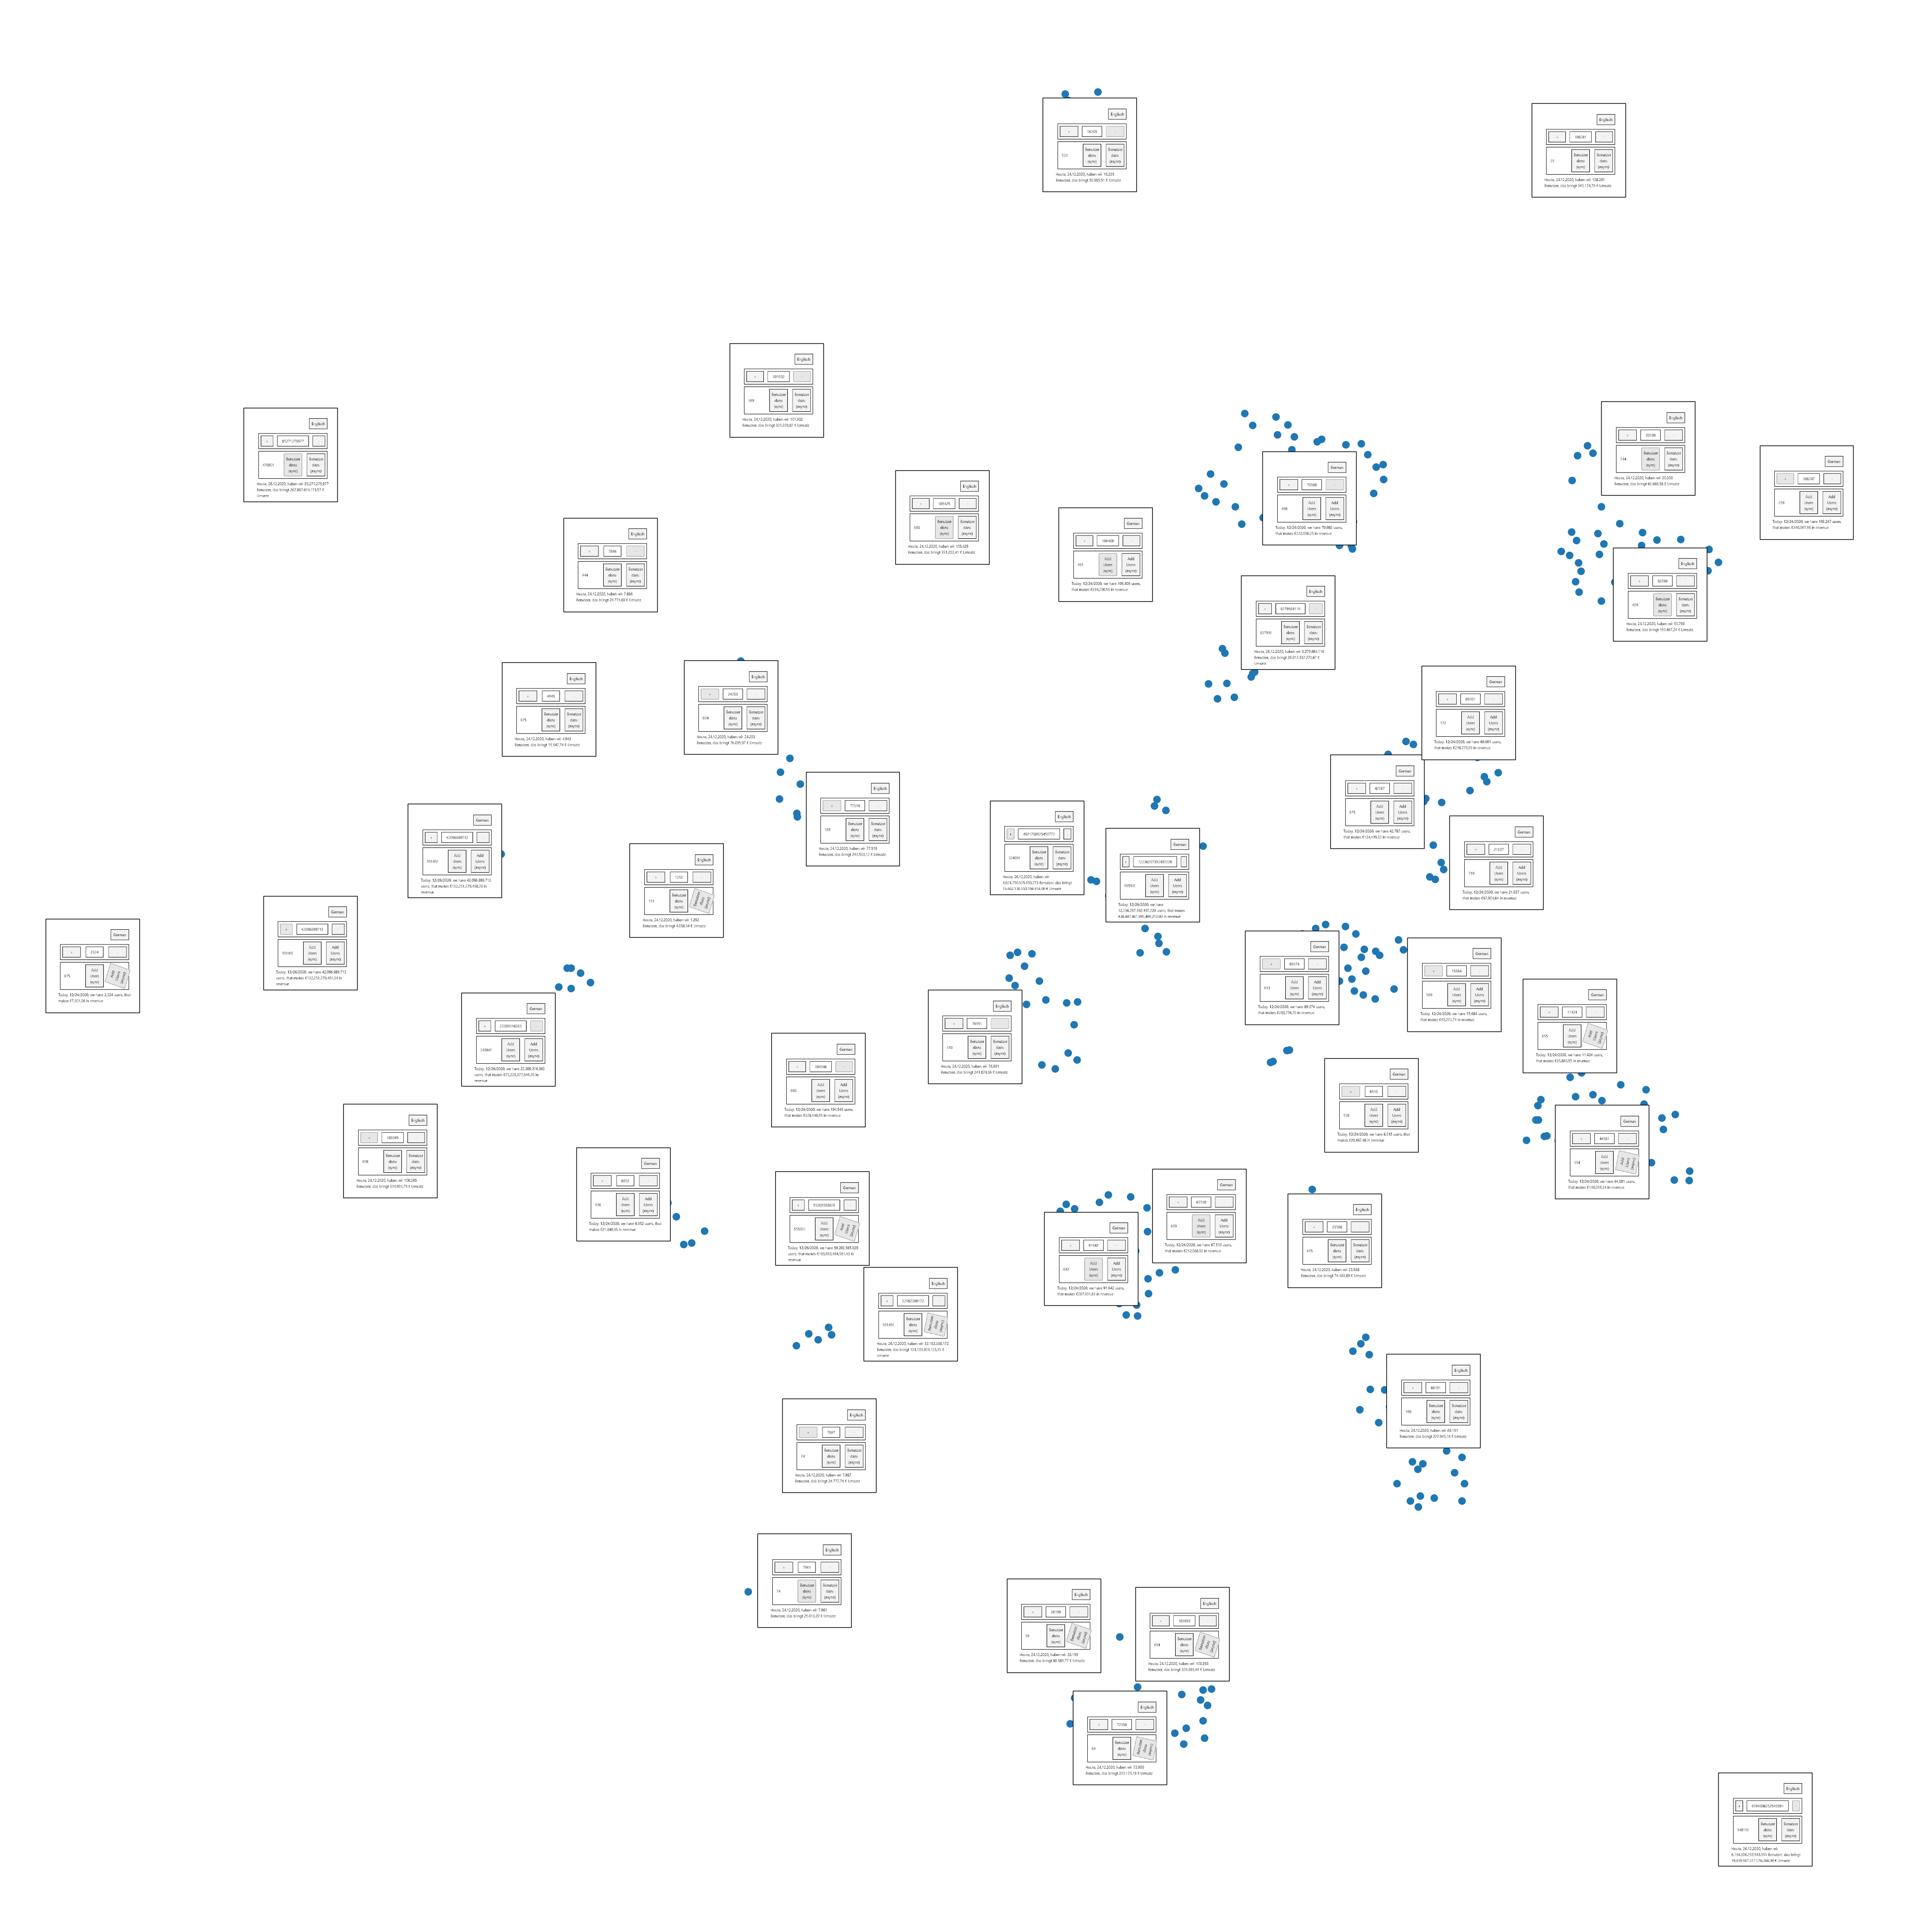

In [62]:
plot_embeddings(train_embedded_imgs, train, min_dist=min_dist, zoom=0.5, plot_samples=True)

# Step 6: Clustering and looking into clusters

## HDBSCAN

* no parameters at all
* like DBSCAN
* but finds out epsilon by itself

https://github.com/scikit-learn-contrib/hdbscan

https://umap-learn.readthedocs.io/en/latest/faq.html#can-i-cluster-the-results-of-umap



In [63]:
!pip install -q hdbscan

In [64]:
import hdbscan

In [65]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

def plot_dataset(X, y_pred=[0], fname=None, highlights=None):
    # last color is black to properly display label -1 as noise (black)
    colors = np.append(np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1)))), ['#000000'])
    plt.figure(figsize=(10, 10))

    if highlights is None:
          plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
    else:
      plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred], alpha=0.2)
      plt.scatter(highlights[:, 0], highlights[:, 1], s=20, 
                  edgecolors='k',
                  color='w')

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    if fname:
        plt.savefig(fname)


In [66]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
cluster_labels = clusterer.fit_predict(train_embedded_imgs)
train_embedded_imgs.shape, cluster_labels.shape

((603, 2), (603,))

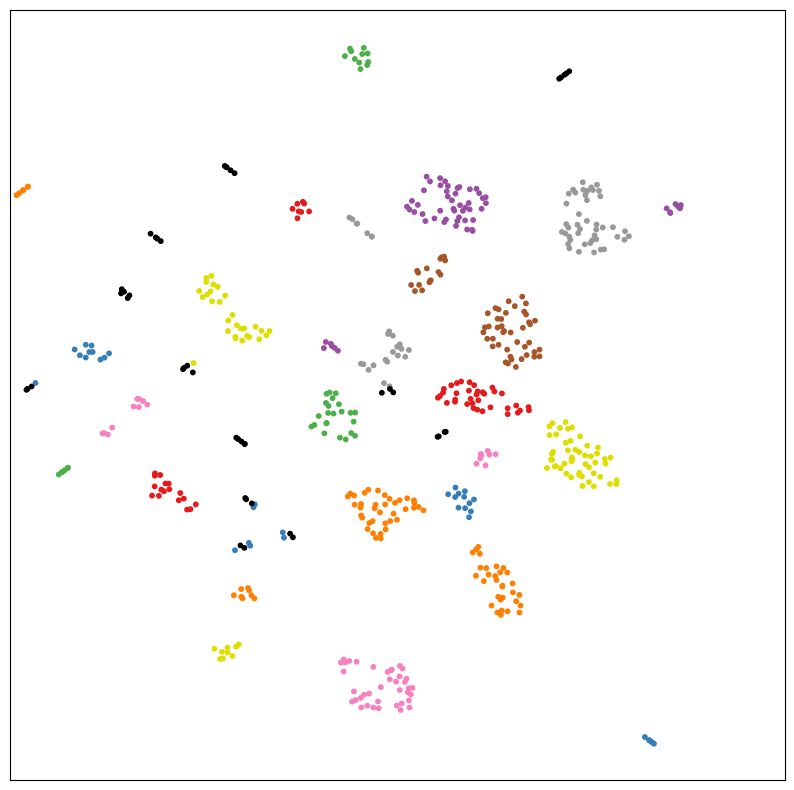

In [67]:
plot_dataset(train_embedded_imgs, cluster_labels)

In [68]:
labels, indices, inverse, counts = np.unique(cluster_labels, return_counts=True, return_index=True, return_inverse=True)
labels.shape, indices.shape, inverse.shape, counts.shape

((30,), (30,), (603,), (30,))

In [69]:
# sizes of clusters high to low
np.sort(counts)[::-1]

array([50, 46, 45, 44, 43, 39, 38, 36, 31, 29, 23, 18, 17, 16, 12, 11, 11,
       10,  9,  8,  8,  8,  7,  7,  7,  6,  6,  6,  6,  6])

In [70]:
# which clusters contain the most samples (outliers is 0)
cluster_nr_ranking = np.argsort(counts)[::-1]
cluster_nr_ranking

array([27, 15,  0,  7, 23,  4, 20, 26, 11, 18, 12, 25,  8, 14, 19, 10,  3,
       22,  9, 13, 17, 29, 16, 28,  6, 21,  5, 24,  2,  1])

In [71]:
ranking = 0
# ranking = 1
# ranking = 3
cluster_nr = cluster_nr_ranking[ranking]

cluster_points = np.where(inverse == cluster_nr)[0]
highlights = train_embedded_imgs[cluster_points]
higlight_images = train[cluster_points]
cluster_nr, highlights.shape

(27, (50, 2))

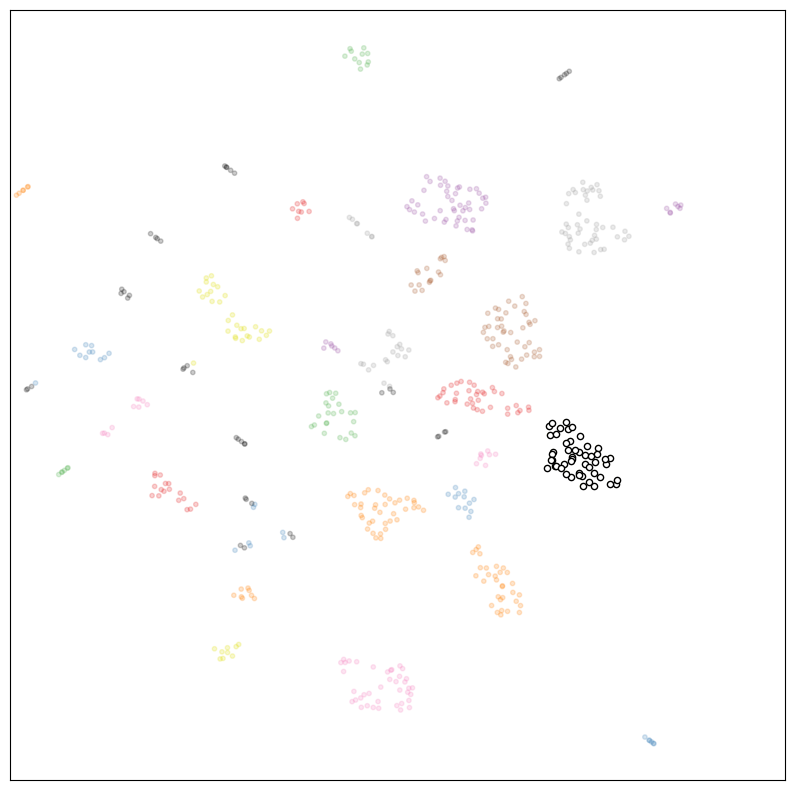

In [72]:
plot_dataset(train_embedded_imgs, cluster_labels, highlights=highlights)

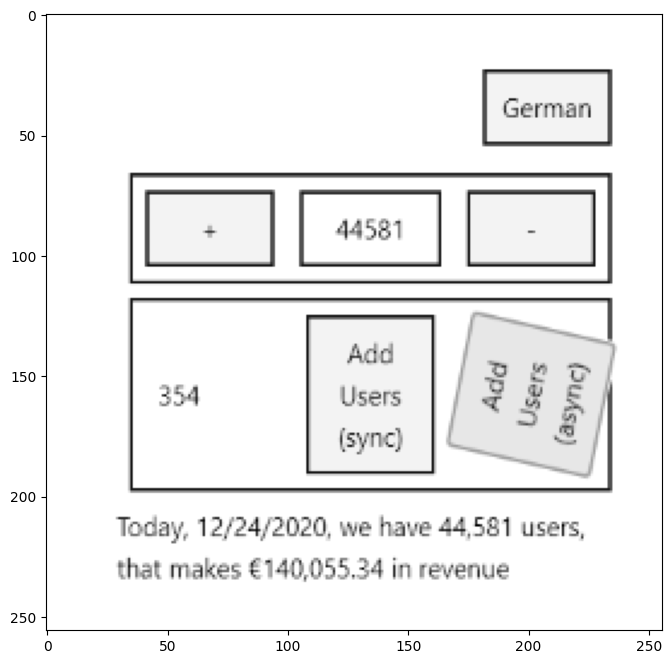

In [73]:
plt.imshow(higlight_images[0], cmap='gray');

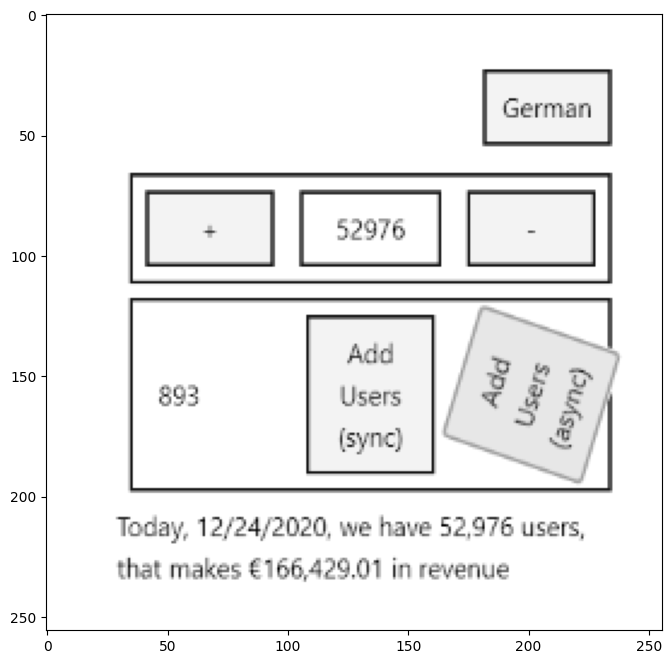

In [74]:
plt.imshow(higlight_images[10], cmap='gray');